# Implementation of Quantum Annealing in QISKIT

We aim to implement in a circuit model a quantum annealing process that searches for the ground state of an Ising Hamiltonian. This is not an usual task in a real (digital) quantum computer like the ones available through the IBM Q system. It is normally more efficient to physically build a quantum device that implements this Hamiltonian (e.g. the D-Wave machine). 

However, explicilty inducing quantum dynamics associated to the quantum Ising Hamiltonian is a pedagogical exercise that will teach you very useful ideas on quantum simulation and variational quantum computing.

The Ising interaction Hamiltonian takes the form

$$ H_{Ising}  = \frac{1}{2} \sum_{j,k} J_{j k} \sigma^z_j \sigma^z_l + \sum_h h^z_j \sigma^z_j $$.


We have to add a quantum term describing the action of a magnetic field in the $x-$direction. Overall, the time dependent Hamiltonian that we aim to implement is:

$$ H(t) = h \sum_j \sigma^x_j  + g(t) \left( \frac{1}{2} \sum_{j,k} J_{j k} \sigma^z_j \sigma^z_l + \sum_h h^z_j \sigma^z_j  \right)$$

The field $h$ is kept constant. The parameter $g(t)$ controls the interaction strength and it is increased from $g(0) = 0$ to $g(T) = g_f$, with $g_f$  large enough such that the z-z interactions have a dominant effect in determining the ground state of the Hamiltonian. We will fix later the functional form of $g(t)$.

The initial quantum state of the spin system is the ground state of $H(t = 0)$,

\begin{eqnarray}
| \psi(0) \rangle &=& \frac{1}{2^{n/2}} \bigotimes_j \left( |0\rangle_j + | 1 \rangle_j \right) = 
\nonumber \\
               &=&   \bigotimes_j H_j |0\rangle_j  .
\end{eqnarray}

where we have assumed that $h < 0$ and in the last step we have used the fact that the initial state can be created by means of $n$ Hadamard gates.

In [4]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

## Define gates

We start by defining gates. Although this is simple, one has to dedicate some time to come up with an implementation of the Ising interaction gate. If you consider qubits 1 and 2, for example, the gate that we need would act like this:

$$ U_{Ising}(\alpha) =  e^{-i \alpha \sigma^z_1 \sigma^z_2}$$

In a quantum annealing algorithm, $\alpha = J(t) \Delta t$, with $J(t)$ the interaction at time $t$ and $\Delta t$ the time step used in the Trotterization. We also define gates implementing the magnetic fields and the the initialization circuit. For this we use rotation matrices. The quantum evolution induced by the magnetic field in the $x$-direction is implemented with a gate of the form  

$$ Rx(\theta) = e^{i (\theta/2) \sigma^x }$$

whereas the magnetic field in the $z$-direction is implemented by the gate

$$ Rz(\theta) = e^{i (\theta/2) \sigma^z }$$

In [5]:
def ising_gate(circuit,qrj,qrl,Jt):
    circuit.cx(qrj,qrl)
    circuit.u1(-2*Jt,qrl)
    circuit.cx(qrj,qrl)  

### * Exercise 1: 

Using pen and paper, show that this "ising_gate" is equivalent to the unitary operation $U_{Ising}$ defined above.

Below we also add definitions for circuits implementing the Trotter steps corresponding to the action of the magnetic fields acting on the qubits in the x and z directions.

In [6]:
def fieldx_gate(circuit,qrj,Bt):
    # We use rotation around x 
    circuit.rx(-2*Bt,qrj)

def fieldz_gate(circuit,qrj,Bt):
    circuit.rz(-2*Bt,qrj)

In [7]:
def initialize_qa(circuit,qr):
    circuit.h(qr)

In [8]:
qr = QuantumRegister(2)
cr = QuantumRegister(2)
circuit = QuantumCircuit(qr)
initialize_qa(circuit,qr)
ising_gate(circuit,qr[0],qr[1],1)
fieldx_gate(circuit,qr,1)

The following picture is a visualization te initialization + Ising gate + rotations around x, lead to the following circuit. 

The initialization step consists of a series of Hadamard gates that prepare the state 

$| \psi(0) \rangle = \frac{1}{2^{n/2}} \bigotimes_j \left( |0\rangle_j + | 1 \rangle_j \right) = \bigotimes_j H_j |0\rangle_j $

Then we have an Ising gate, and finally a rotation around x (corresponding to the action of a magnetic field in the x-direction)

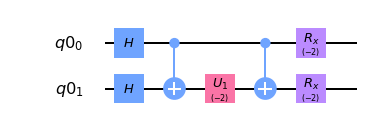

In [9]:
circuit.draw(output='mpl')

### *  Exercise 2 

Write down a circuit and run it to check numerically that the ising_gate function defined above really works. You can take as a starting point the circuit above. You could, for example, predict the output of such circuit under different combinations of gates and checke that the final measurement agrees with your calculation.

## Quantum annealing circuit

Ideally, our quantum annealing algorithm would work by implementing the following quantum dynamics,

\begin{equation}
|\psi(t) \rangle = U_{qa} |\psi(t) \rangle =
Texp  \left( -i \int_0^T \left( h \sum_{j} \sigma^x_j + g(t) H_{ising} \right) \right) |\psi(0) \rangle
\end{equation}

We have to Trotterize this expression by using an approximation of the form

$$e^{-i H(t_1) \Delta t - i H(t_2) \Delta t } \approx  e^{-i H(t_1) \Delta t} e^{- i H(t_2) \Delta t }, $$

which holds as long as $| [ H(t_1) , H(t_2) ]| \Delta t \ll 1$.

To make things easy, let us choose energy units such that $h = 1$. We will also assume that Ising couplings are of the order of $1$. (More strictly, we have to assume that $\sum_j J_{j k} \ll 1$, that is, if you take the matrix $J$, then column-wise summations are of order of 1 or less). Note that, since $J_{jk}$ is multiplied by $g$, the coupling matrix can always be normalized to satisfy this condition and the extra factor be absorbed in $g$.

Finally we have to choose $g(t)$, which has to interpolate between $g(0) = 0$ and some value $g \gg 1$ over the duration of the quantum annealing evolution, $T$. We choose an exponential evolution of the form,

$$ 
g(t) = g_0 \left( 1 - e^{- t/T} \right) .
$$

The value $1/T$ is chosen so that at time $t = T$, $g = g_0 (1/e)$. As a value of $g_0$ we can choose $g_0 = 5$ or $10$, so that the interaction term is much larger than the magnetic field term at the end of the evolution.

Finally, we have to deal with Trotterization. For this we need to choose a number of steps $N_{steps}$, such that the time step can be obtained from the total time

$$
\Delta t = \frac{T}{N_{steps}}
$$

Putting all together, the circuit that we need to implement is

\begin{equation}
U_{qa} = \prod_{j=1}^{N_{steps}} 
\left( 
e^{- i \ h  \sum_j \sigma^x_j} e^{- i \ g(t_n) H_{ising}}.
\right)
\end{equation}



### * Exercise 3: 
Compose a circuit that implements the quantum annealing dynamics. (If this is too difficult, just be creative and try to find out a way to use the Ising interaction for something interesting, e.g. creating entangled states)


### * Exercise 4: 
Use your quantum circuit simulator to study the efficiency of quantum annealing with respect to, for example, the ramp time.